## Spotify's Next Top Model

#### Here we will be hosting a modeling competition that will determine which model deserves to leave this course as Spotify's Next Top Model.


Best of luck to all the contestents! We wish you well, but only the best will rise to the top. There are no participation medals in this game, honey.

In [58]:
# imports  
import statsmodels.api as sm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from gensim.models.word2vec import Word2Vec, KeyedVectors
import html
import re
import itertools
import csv
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.spatial.distance import cdist
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

sns.set_context('poster')
sns.set_palette('muted',color_codes=True)
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# Get the data 
df_trk = utils.make_working_df()
df_trk.head()

,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity,artist_followers,artist_genre,...,pl_mean_trkpop,pl_std_trkpop,art_min_trkpop,art_max_trkpop,art_mean_trkpop,art_std_trkpop,art_total_trks,art_class,user_pls_in_sample,pl_desc_chars
0,2013-09-30 16:12:24,Allgott & Villgott,119907.0,0.0,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0,76.0,None,...,1.333333,1.505545,0.0,6.0,1.764706,1.888432,13,trash_factory,515,0
1,2013-10-05 15:22:13,Allgott & Villgott,67918.0,0.0,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0,76.0,None,...,1.333333,1.505545,0.0,6.0,1.764706,1.888432,13,trash_factory,515,0
2,2014-07-16 13:50:24,J Boog,217270.0,0.0,4RjHalDdUreXDJSJLo44lK,Sunshine Girl,35XFuuqgCvTYQARix7CFpm,53.0,103793.0,[polynesian pop],...,38.269231,22.298982,0.0,58.0,38.419355,17.651769,20,star,166,0
3,2014-07-06 09:12:01,Brennan Heart,222919.0,0.0,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0,122496.0,[hardstyle],...,15.510000,15.835962,0.0,47.0,11.272727,16.736563,18,trash_factory,166,0
4,2012-06-29 11:53:52,Johnny Ray,153375.0,0.0,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0,1281.0,None,...,0.000000,0.000000,0.0,0.0,0.000000,NaN,1,garage_band,1731,0


In [3]:
# Drop these columns because we dont need them for anything in modeling or EDA
df_trk = df_trk.drop(['pl_desc','pl_name','celeb_name'],axis=1)

In [4]:
df_trk.columns

Index(['trk_added_at', 'art_name', 'trk_duration', 'explicit', 'trk_id',
       'trk_name', 'pl_id', 'trk_popularity', 'artist_followers',
       'artist_genre', 'artist_id', 'artist_pop', 'collab', 'pl_followers',
       'pl_num_trks', 'pl_owner', 'cluster', 'cluster_norm', 'is_celeb',
       'user_followers', 'pl_first_date', 'pl_last_date', 'pl_days_active',
       'pl_days_old', 'pl_num_trk', 'pl_num_art', 'pl_min_trkpop',
       'pl_max_trkpop', 'pl_mean_trkpop', 'pl_std_trkpop', 'art_min_trkpop',
       'art_max_trkpop', 'art_mean_trkpop', 'art_std_trkpop', 'art_total_trks',
       'art_class', 'user_pls_in_sample', 'pl_desc_chars'],
      dtype='object')

## EDA:

We explore the data (and our engineered features) at both the track and the playlist level.  As we can see below, we have about 9.7 playlists per user when we include all users. Below, when we drop playlists with below 1 follower, we have about 4.4 playlists per user.  Likewise, we start with ~368k tracks and after we drop the playlists with fewer than 1 follower we only have ~211k tracks remaining.

In [5]:
print('We have {} unique spotify playlist owners.'.format(len(df_trk['pl_owner'].unique())))
print('We have {} unique spotify playlists.'.format(len(df_trk['pl_id'].unique())))

We have 846 unique spotify playlist owners.
We have 8183 unique spotify playlists.


In [6]:
# Make a playlist data subset as we'll use this often for EDA.  

df_pl_columns = ['pl_id', 'pl_days_old', 
                 'pl_days_active', 'pl_num_trk', 'pl_num_art', 
                 'pl_min_trkpop', 'pl_max_trkpop', 'pl_mean_trkpop', 
                 'pl_followers', 'pl_num_trks','pl_desc_chars'] 

df_pl = df_trk.groupby('pl_id').first().reset_index()[df_pl_columns]

In [7]:
print("Master DF has total of {0} rows/tracks (including zero followers)".format(df_trk.shape[0]))

# Cut out the zero- and one- follower playlists
# Cutting one-follower playlists because it's likely just an individual following their own list
df_trk = df_trk[df_trk['pl_followers'] > 1]
print("Master DF has total of {0} rows/tracks (after removing zero followers) \n".format(df_trk.shape[0]))

Master DF has total of 367911 rows/tracks (including zero followers)
Master DF has total of 210798 rows/tracks (after removing zero followers) 



In [8]:
print('We have {} unique spotify users who own a playlist with > 1 follower.'.format(len(df_trk['pl_owner'].unique())))
print('We have {} unique spotify playlists with > 1 follower.'.format(len(df_trk['pl_id'].unique())))

We have 779 unique spotify users who own a playlist with > 1 follower.
We have 3422 unique spotify playlists with > 1 follower.


#### Playlist followers:
Engineering   more   features   around   artist and   playlist   data   yielded   interesting relationships.   A   cursory   measure   of   playlist success,   our   generalized   project   goal,   is the   number   of   followers   per   playlist.   The histograms   to   the   right   show   a   significant right-skew,   with   most   playlists   having   few followers   and   a   few   approaching   the   1M mark.   The   log-transform   of   followers illustrates   a   potentially   more   useful response   variable.

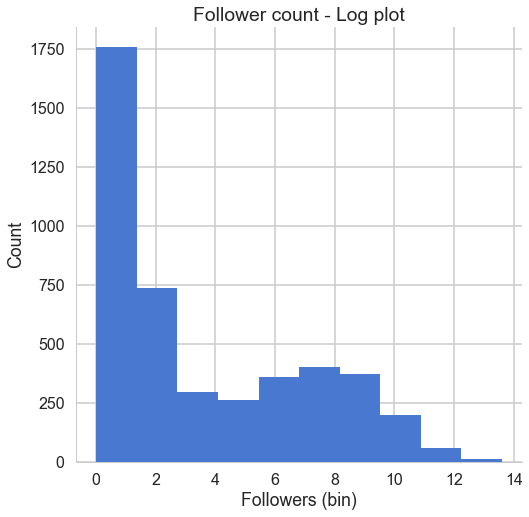

In [9]:
# Plot histogram of follower counts for each playlist
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(np.log(df_pl[df_pl['pl_followers']>0].pl_followers))
ax.set_title("Follower count - Log plot")
ax.set_xlabel("Followers (bin)")
ax.set_ylabel("Count")
sns.despine()

##### Artist analysis:

We   separated   artists   into   five   distinct   categories   using   combinations   of   their   mean   popularity   and   total   number   of   tracks   as follows:    superstar ,     star ,     one_hit_wonder ,   garage_band ,    and     trash_factory .
These   categories   should   be   self-descriptive,   but   the   two   plots   below   do   a   fantastic   job   of   illustrating   each   in   terms   of   their thresholds   and   relationships.      The   artist   popularity   metric   ties   out   with   our   expectations   because   we   see   people   like   Post Malone,   Camila   Cabello,   and   Ed   Sheeran   in   our   superstar   category.

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/paulblankley/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


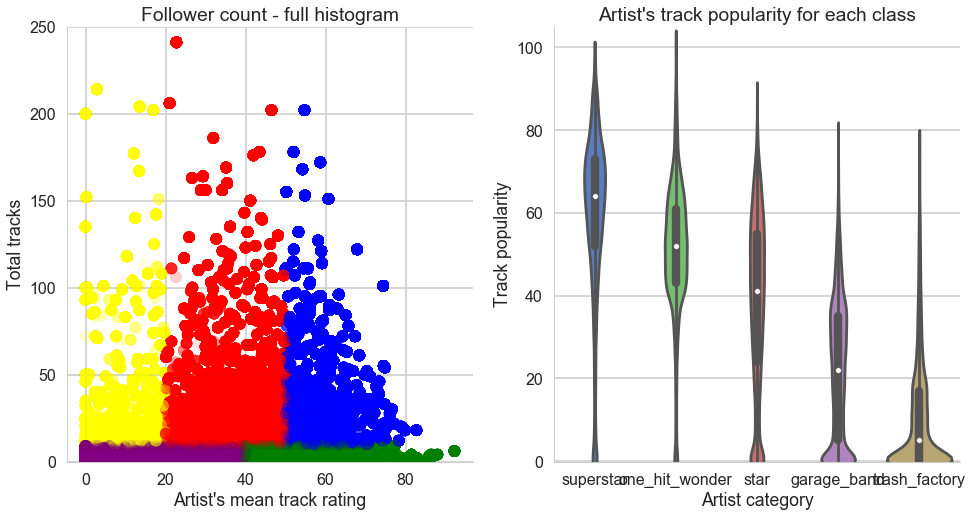

In [10]:
# Plot follower count vs. average track popularity
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,8))

colors = {'superstar':'blue', 'star':'red', 'trash_factory':'yellow', 'one_hit_wonder':'green', 'garage_band':'purple'}

ax1.scatter(df_trk.art_mean_trkpop, df_trk.art_total_trks, alpha = 0.1, c=df_trk['art_class'].apply(lambda x: colors[x]))
ax1.set_title("Follower count - full histogram")
ax1.set_xlabel("Artist's mean track rating")
ax1.set_ylabel("Total tracks")
ax1.set_ylim((0,250))

order = ['superstar','one_hit_wonder','star','garage_band','trash_factory']

sns.violinplot(data=df_trk, y='trk_popularity',x='art_class',order=order,ax=ax2)
ax2.set_title("Artist's track popularity for each class")
ax2.set_xlabel("Artist category")
ax2.set_ylabel("Track popularity")
ax2.set_ylim((-0.1, 105))

sns.despine(top = True, right = True)

#### Continuing Artist Analysis:
Comparing   these   five   artist   categories   with   specific   track popularities   (as   determined   by   Spotify)   and   those   tracks’ playlists’   followers   shows   us   that   not   only   do   most   playlists incorporate   popular   artists   (red/blue),   but   a   lot   of   them   have the   “superstar”   artists’   best   songs   (the   mostly   blue   right   side),   as well   as   a   smattering   of   “one-hit-wonders”   (red   in   the   middle) and   a   dense   area   of   moderately   popular   songs   throughout (between   30   and   70   popularity).   This   relationship   and   playlist architecture   should   also   be   intuitive,   and   the   scatterplot   below   illustrates   it   well.

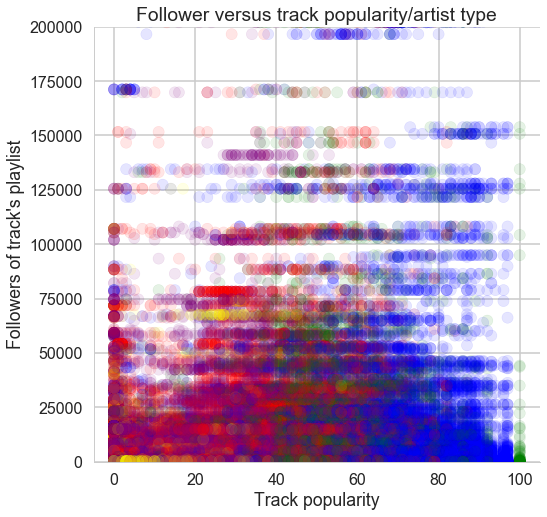

In [11]:
# Plot follower count vs. average track popularity
fig, ax = plt.subplots(figsize = (8,8))

colors = {'superstar':'blue', 'star':'red', 'trash_factory':'yellow', 'one_hit_wonder':'green', 'garage_band':'purple'}

ax.scatter(df_trk['trk_popularity'], df_trk['pl_followers'], alpha = 0.1, c=df_trk['art_class'].apply(lambda x: colors[x]))
ax.set_title("Follower versus track popularity/artist type")
ax.set_xlabel("Track popularity")
ax.set_ylabel("Followers of track's playlist")
ax.set_ylim((0,200000))
sns.despine(top = True, right = True)

##### Time and playlists
It   appears   that   there   may   be   a   relationship   between   the   number of   tracks   a   playlist   has   and   its   number   of   followers   (top-left),   as well   as   length   of   its   description (top-right).  We   also   investigated   the   impact   of   playlist   turnover   rate,   or   relative   age, days   between   the   oldest   and   newest   track   being added (bottom-left),   as   well   as   the  age of the oldest song   on   playlist   follower   count   (bottom-right).

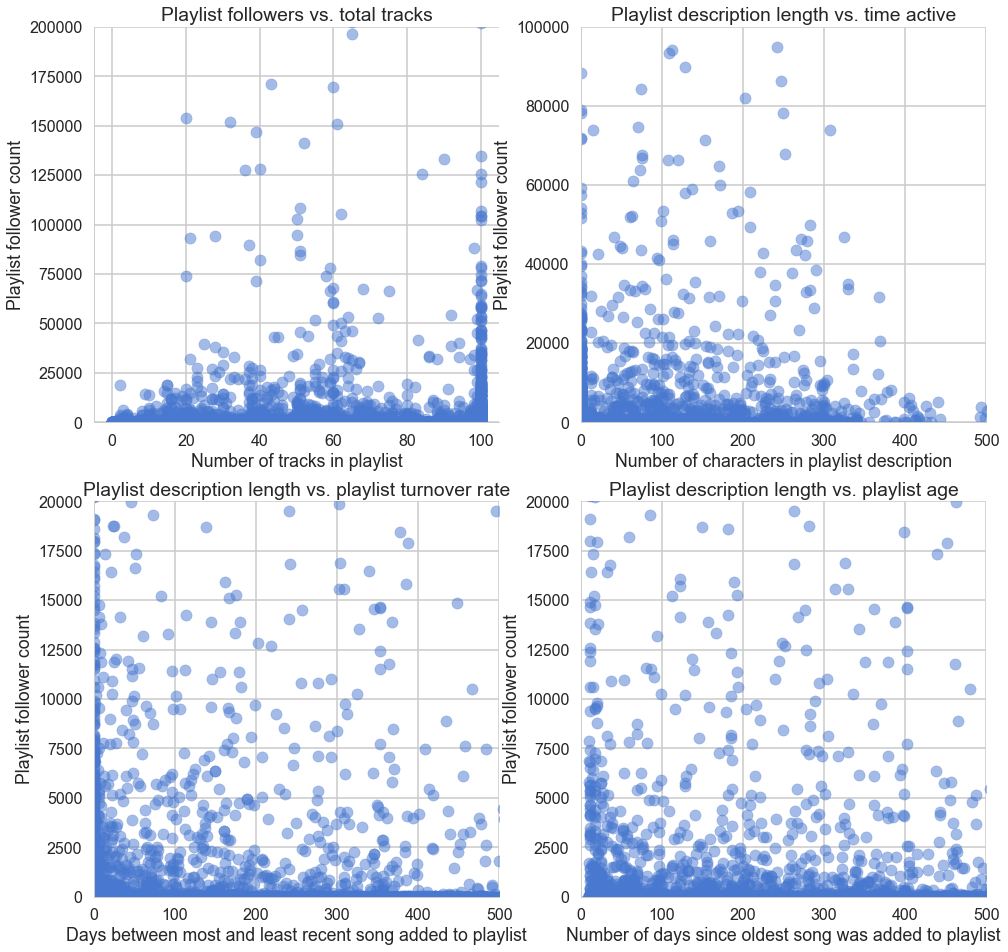

In [12]:
# Test if bigger playlists have more followers
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize = (16,16))
ax1.scatter(df_pl.pl_num_trk, df_pl.pl_followers, alpha = 0.5)
ax1.set_title("Playlist followers vs. total tracks")
ax1.set_xlabel("Number of tracks in playlist")
ax1.set_ylabel("Playlist follower count")
ax1.set_ylim((0,200000))

ax2.scatter(df_pl.pl_desc_chars, df_pl.pl_followers, alpha = 0.5)
ax2.set_title("Playlist description length vs. time active")
ax2.set_xlabel("Number of characters in playlist description")
ax2.set_ylabel("Playlist follower count")
ax2.set_ylim((0,100000))
ax2.set_xlim((0,500))

ax3.scatter(df_pl.pl_days_active, df_pl.pl_followers, alpha = 0.5)
ax3.set_title("Playlist description length vs. playlist turnover rate")
ax3.set_xlabel("Days between most and least recent song added to playlist")
ax3.set_ylabel("Playlist follower count")
ax3.set_ylim((0,20000))
ax3.set_xlim((0,500))

ax4.scatter(df_pl.pl_days_old, df_pl.pl_followers, alpha = 0.5)
ax4.set_title("Playlist description length vs. playlist age")
ax4.set_xlabel("Number of days since oldest song was added to playlist")
ax4.set_ylabel("Playlist follower count")
ax4.set_ylim((0,20000))
ax4.set_xlim((0,500))

sns.despine(top = True, right = True)

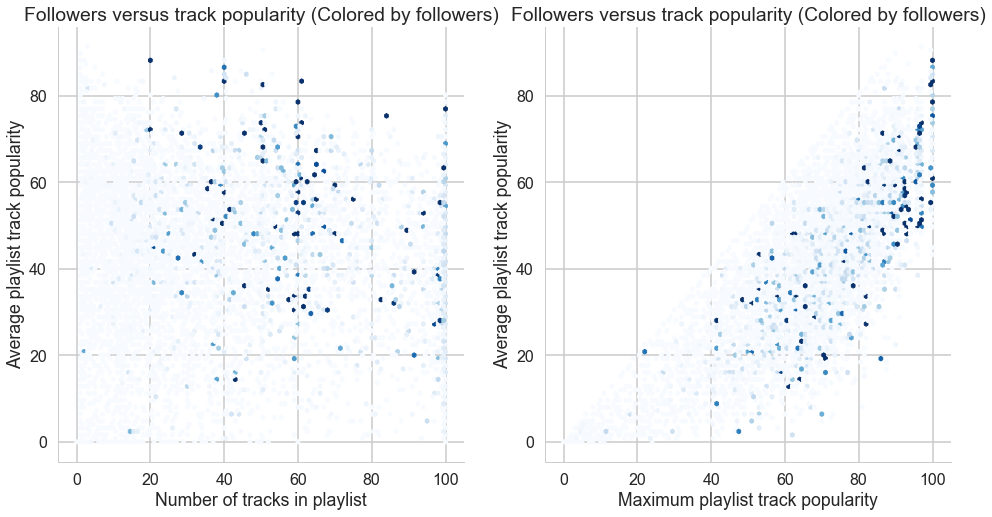

In [86]:
# Test playlist mean/max popularity versus follower count
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,8))
ax1.hexbin(df_pl.pl_num_trk, df_pl.pl_mean_trkpop, C=df_pl.pl_followers, cmap='Blues', gridsize = 100, vmax=35000)
ax1.set_title("Followers versus track popularity (Colored by followers)")
ax1.set_xlabel("Number of tracks in playlist")
ax1.set_ylabel("Average playlist track popularity")

ax2.hexbin(df_pl.pl_max_trkpop, df_pl.pl_mean_trkpop, C=df_pl.pl_followers, cmap='Blues', gridsize = 100, vmax=25000)
ax2.set_title("Followers versus track popularity (Colored by followers)")
ax2.set_xlabel("Maximum playlist track popularity")
ax2.set_ylabel("Average playlist track popularity")
sns.despine(top = True, right = True)

In [14]:
len(df_trk)

210798

In [15]:
# Blow out the dataframe by genre
df_trk['artist_genre'] = [g if type(g)==list else [] for g in df_trk['artist_genre']]
bigdf = utils.explode_value(df_trk[['artist_genre','pl_followers','artist_pop']],'artist_genre')

In [16]:
len(df_trk)

210798

In [17]:
genres_by_artist_pop = bigdf[['artist_genre','artist_pop']].groupby('artist_genre',as_index=False\
                                                    ).mean().sort_values('artist_pop',ascending=False).head(15)
genres_by_pl_followers = bigdf[['artist_genre','pl_followers']].groupby('artist_genre',as_index=False\
                                                    ).median().sort_values('pl_followers',ascending=False).head(15)

##### Genres: 

Here we see some of the genres that show up in the most popular playlists by followers.  The barplot directly below is by the median number of playlist followers, so as to be less sensitive to outliers.  The barplot below this one is based on mean artist popularity by genre. As we can see, there are some specific genres at the top that we would usually associate with one artist (canadian pop - Justin Bieber, detroit hip hop - Eminem). It is likely those artists are skewing the distribution, since those are their respective genres. Sadly, we do not have enough members of each genre to get a good view of the most popular genres by artist.

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


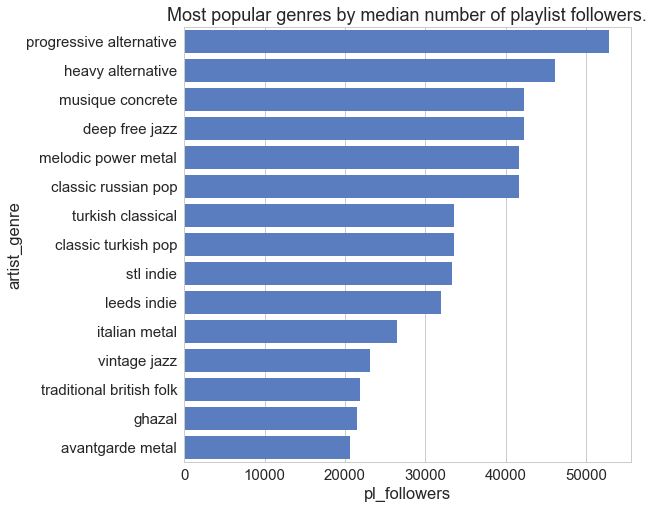

In [87]:
sns.set(font_scale=1.5)
sns.set_palette('muted',color_codes=True)
sns.set_style('whitegrid')

fig,ax = plt.subplots(figsize=(8,8))
sns.barplot(data=genres_by_pl_followers,y='artist_genre',x='pl_followers',color='b',ax=ax)
plt.title('Most popular genres by median number of playlist followers.')

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


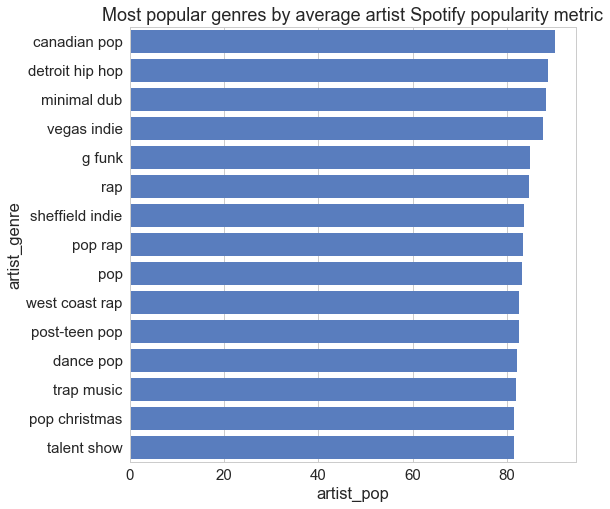

In [88]:
fig,ax = plt.subplots(figsize=(8,8))
sns.barplot(data=genres_by_artist_pop,y='artist_genre',x='artist_pop',color='b',ax=ax)
plt.title('Most popular genres by average artist Spotify popularity metric')

## Merge in the genre features:

We are waiting until now to merge in the genre features to save memory in the above exercises.

In [20]:
# Merge in the genre features
df_full = utils.join_genre_features(df_trk)
df_full = df_full.drop('artist_genre',axis=1)
assert(len(df_trk)==len(df_full))

##### Playlist level genres:

Below we look at the most common genre by number of playlist occurances.  Here we use the "mode genre" field.  This field is made by looking at all the genres that make up a playlist (on a track level) and choosing the most common (mode).

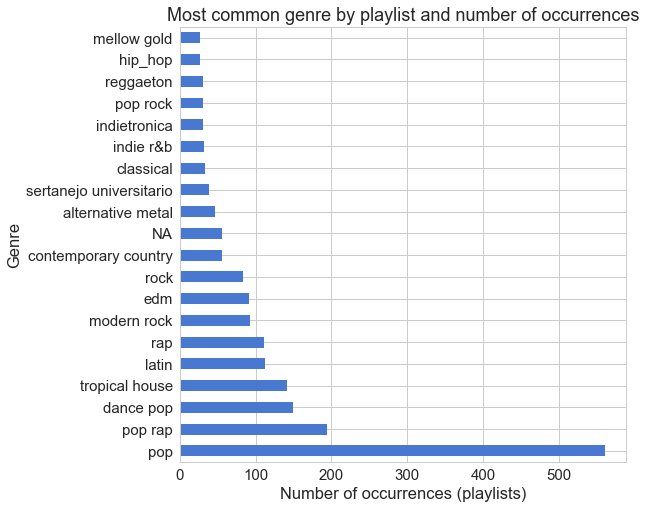

In [89]:
fig, ax = plt.subplots(figsize=(8,8))

df_full[['pl_id','mode_genre']].drop_duplicates()['mode_genre'].value_counts()[:20].plot(kind='barh',color='b',ax=ax)
ax.set_title('Most common genre by playlist and number of occurrences')
ax.set_xlabel('Number of occurrences (playlists)')
ax.set_ylabel('Genre')

### Track level genres:

Here we take a quick look at some genre-type information.  By genre type we mean, we are looking at any sub-genres that fall in a larger, more general genre.  For example, 'classic rock', 'heavy rock', and 'swedish electronic pop rock' would all fall in our 'rock' genre-type.  For each genre related to a song we have binary variables to indicate whether that genre-type is present in the track.  The genre types below represent the 15 most common genres in our dataset. 

In [22]:
df_full.columns

Index(['trk_added_at', 'art_name', 'trk_duration', 'explicit', 'trk_id',
       'trk_name', 'pl_id', 'trk_popularity', 'artist_followers', 'artist_id',
       'artist_pop', 'collab', 'pl_followers', 'pl_num_trks', 'pl_owner',
       'cluster', 'cluster_norm', 'is_celeb', 'user_followers',
       'pl_first_date', 'pl_last_date', 'pl_days_active', 'pl_days_old',
       'pl_num_trk', 'pl_num_art', 'pl_min_trkpop', 'pl_max_trkpop',
       'pl_mean_trkpop', 'pl_std_trkpop', 'art_min_trkpop', 'art_max_trkpop',
       'art_mean_trkpop', 'art_std_trkpop', 'art_total_trks', 'art_class',
       'user_pls_in_sample', 'pl_desc_chars', 'has_alternative',
       'has_christmas', 'has_country', 'has_dance', 'has_deep', 'has_hip_hop',
       'has_house', 'has_indie', 'has_jazz', 'has_latin', 'has_metal',
       'has_pop', 'has_rap', 'has_rock', 'has_soul', 'no_genre', 'mode_genre'],
      dtype='object')

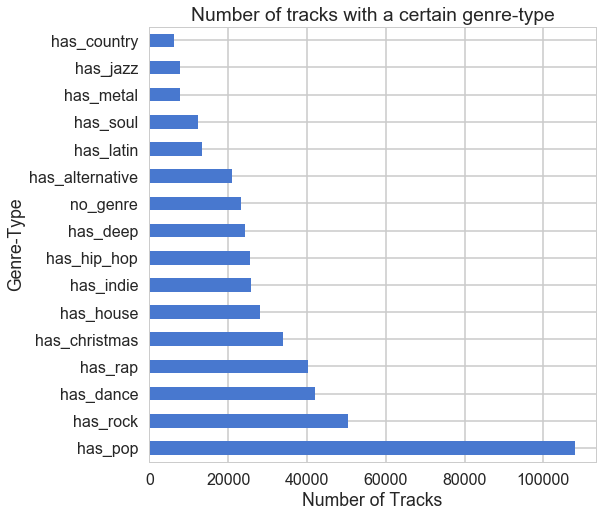

In [23]:
sns.set(font_scale=1.5)


fig,ax = plt.subplots(figsize=(8,8))

mc_genres = ['has_alternative', 'has_christmas', 'has_country', 'has_dance',
       'has_deep', 'has_hip_hop', 'has_house', 'has_indie', 'has_jazz',
       'has_latin', 'has_metal', 'has_pop', 'has_rap', 'has_rock', 'has_soul','no_genre']
df_full[mc_genres].sum(axis=0).sort_values(ascending=False).plot(kind='barh',color='b',ax=ax)
ax.set_title('Number of tracks with a certain genre-type')
ax.set_ylabel('Genre-Type')
ax.set_xlabel('Number of Tracks')

### Celebrity playlist owners:

One more important factor we'd like to control is whether the owner of the playlist is a known celebrity.  The motivation for this is that some of the most popular playlists we've seen have been from a celebrity's official spotify account.  We'd like to be able to account for this bias.

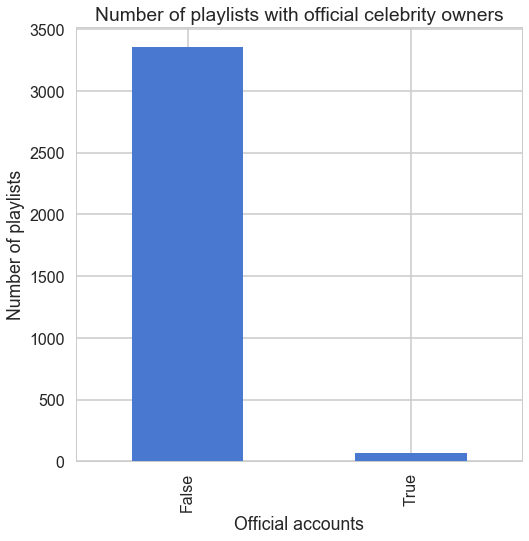

In [24]:
# Add new feature 'pl_official' if the play is owned by an account with the word 'official' in it
df_full['is_official'] = df_full.pl_owner.str.contains('official') == 1

# Plot the number of official and unoffical playlists
fig,ax = plt.subplots(figsize=(8,8))

df_full.groupby(['is_official'])['pl_id'].nunique().plot(kind='bar',color='b',ax=ax)
ax.set_title('Number of playlists with official celebrity owners')
ax.set_ylabel('Number of playlists')
ax.set_xlabel('Official accounts')

## 209 Section - Word 2 Vec feature based on Playlist Name

#### Motivation:
We will walk through the construction of our 209-level feature.  We will apply a word-to-vec transform to as many applicable words as there are in the set of playlist names.  The core intuition behind this, is that the playlist name is what represents the playlist to the outside world.  A bad playlist name can keep people from following or listening to it, even if the content is great, while a good playlist name can draw users.  The playlist name also, hopefully, categorizes the playlist in a meaningful way to the used.  This categorization could be by genre, mood, activity or any other type of category the playlist creator thought was useful.  

#### Techique:
This exercise seeks to cluster the playlist names into meaningful categories based on the normalized sum of the vectors of known words in the playlist.  This will aggregate the vector information from each word in the playlist description, with all unknown words set to the zero vector.  We normalize the vectors in one feature (we have a normalized and a not normalized version of this feature) once we aggregate them to stop playlists with just many words from being higher in magnitude than playlists with just a few words.  

#### Difficulties:
Ultimately, there will be some difficulties with misspellings, different languages, and internet slang, and we will doubtless lose information in this quick application of word-to-vec, but we think the output will still be a meaningful feature in our final model.  We have corrected for an many of these as was quickly possible with some simple NLTK and regex tools. 

##### Model
This Word 2 Vec model was trained with the Text8 wikipedia corpus.  This corpus seemed to be the most applicable one that was still a reasonable size to download to my personal computer and a reasonable time to train the model. After training the model, I added in the "sentences" formed by the playlist names to add several entries to the vocabulary of the model.  Without proper context the model will not denote a vector transform for a word, so there are still several words that do not have a related vector representation.  

##### Sub-optimal data for training
About 84% of the playlist names have at least one meaningful (not a stop word by NLTK standards) word that has a vector representation in our model.  This number could doubtless be improved with a music specific or more casual internet chat area like Twitter or Reddit dataset as opposed to the more formal Wikipedia dataset, but there is only so much time to make our features.


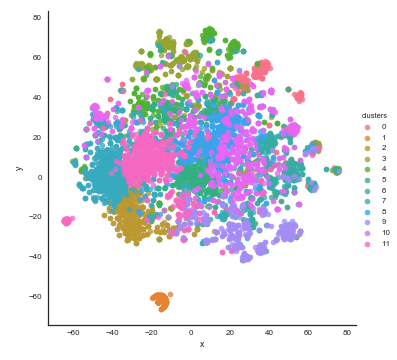

##### TSNE Plot with word locations:

The below plot shows different word locations in a sample of our TSNE plot. As you can see, there is some structure to the word placement.  Toward the bottom, there are several spanish words and realated genres (like salsa, classicos).  We can also see some other consistencies, like "kendrick" and "hip hop" are together in one group, "party", "club" and "pill" are all together in another group.  The Word 2 Vec transform is definitely noisy in this case though.  We think this is due to the smaller training set, and the makeup of the training set. The training set is made up of wikipedia documents which, though they contain a lot of words, probably do not have a lot of the same contexts or slang that we will see here.  If we could train with a corpus from Twitter or Reddit we might have better context for the slang and pithy statements we often see in playlist names.

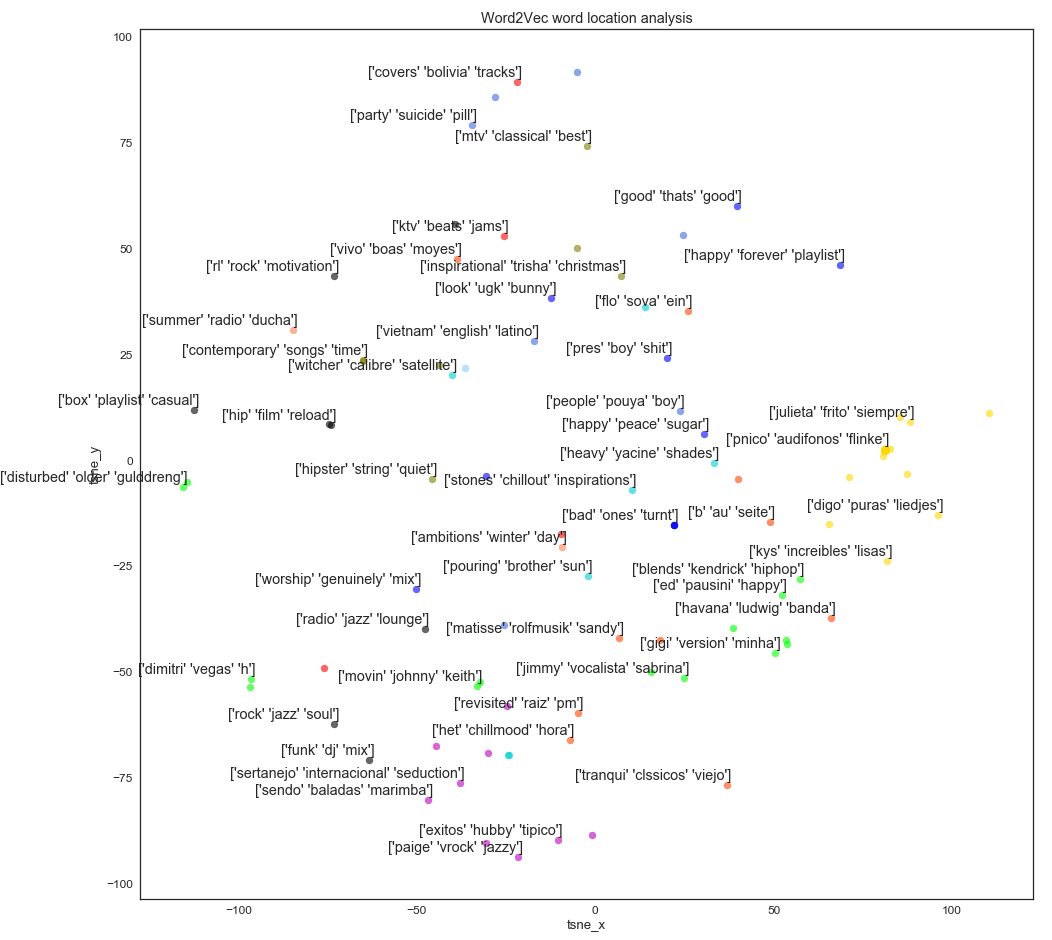

## Now to the modeling!!

First, lets manicure some training / test data.  Again, here we are just going to use the playlists (and realted tracks) that have more than one follower.  The rational behind this is that we don't want to use data that could skew our popularity metrics for tracks if it is unikely that those users have any followers that could potentially follow their playlist. Essentially, we do not think those users have enough presence on Spotify for number of followers to be a meaningful feedback metric for playlist success.

In [25]:
df_full.dtypes

trk_added_at          datetime64[ns]
art_name                      object
trk_duration                 float64
explicit                     float64
trk_id                        object
trk_name                      object
pl_id                         object
trk_popularity               float64
artist_followers             float64
artist_id                     object
artist_pop                   float64
collab                          bool
pl_followers                   int64
pl_num_trks                    int64
pl_owner                      object
cluster                      float64
cluster_norm                 float64
is_celeb                        bool
user_followers               float64
pl_first_date         datetime64[ns]
pl_last_date          datetime64[ns]
pl_days_active               float64
pl_days_old                  float64
pl_num_trk                     int64
pl_num_art                     int64
pl_min_trkpop                float64
pl_max_trkpop                float64
p

In [26]:
# We can drop all of our id's (except for pl_id) and text we will not OH encode.
data = df_full.drop(['pl_owner','collab','trk_name','artist_id','art_name','trk_added_at'],axis=1)
print('We have {} rows.'.format(len(df_full)))
print('We have {} columns.'.format(len(data.columns)))

We have 210798 rows.
We have 49 columns.


In [27]:
data = pd.get_dummies(data=data,prefix=[''],columns=['art_class'])
dcols = ['cluster','trk_id','pl_min_trkpop','pl_max_trkpop','pl_mean_trkpop','art_min_trkpop','art_max_trkpop', \
         'art_mean_trkpop','art_total_trks','user_pls_in_sample']
datat = data.drop(dcols, axis=1)

mapping = {'trk_duration': {'total_duration': 'sum', 'avg_duration': 'mean'}, \
           'explicit': {'number_explicit': 'sum'}, \
           'trk_popularity': {'trk_pop_mean': 'mean', 'trk_pop_max': 'max','trk_pop_min': 'min'}, \
           'artist_followers': {'art_f_mean': 'mean', 'art_f_max': 'max', 'art_f_min': 'min'}, \
           'artist_pop': {'art_pop_mean': 'mean', 'art_pop_max': 'max','art_pop_min': 'min'}, \
           'pl_followers': {'pl_followers': 'first'}, \
           'pl_num_trk': {'pl_num_trk': 'first'}, \
           'cluster_norm': {'cluster_norm': 'first'},
           'is_celeb': {'total_celebs': 'sum'}, \
           'is_official': {'is_official': 'first'}, \
           'user_followers': {'user_f_mean': 'mean', 'user_f_max': 'max', 'user_f_min': 'min'}, \
           'pl_first_date': {'pl_first_date': 'first'}, \
           'pl_last_date': {'pl_last_date': 'first'}, \
           'pl_days_active': {'pl_days_active': 'first'}, \
           'pl_days_old': {'pl_days_old': 'first'}, \
           'pl_num_art': {'pl_num_art': 'first'}, \
           'pl_desc_chars': {'pl_desc_chars': 'first'}, \
           '_superstar': {'num_superstar': 'sum'}, '_star': {'num_star': 'sum'}, \
           '_trash_factory': {'num_trash_factory': 'sum'}, '_one_hit_wonder': {'num_one_hit_wonder': 'sum'}, \
           '_garage_band': {'num_garage_band': 'sum'},
           'has_alternative': {'num_alternative': 'sum'}, 'has_christmas': {'num_christmas': 'sum'}, \
           'has_country': {'num_country': 'sum'}, 'has_dance': {'num_dance': 'sum'}, \
           'has_deep': {'num_deep': 'sum'}, 'has_hip_hop': {'num_hip_hop': 'sum'}, \
           'has_metal': {'num_metal': 'sum'}, 'has_house': {'num_house': 'sum'}, \
           'has_indie': {'num_indie': 'sum'}, 'has_jazz': {'num_jazz': 'sum'}, \
           'has_latin': {'num_latin': 'sum'}, 'has_pop': {'num_pop': 'sum'}, \
           'has_rap': {'num_rap': 'sum'}, 'has_rock': {'num_rock': 'sum'}, \
           'has_soul': {'num_soul': 'sum'}, 'no_genre': {'num_no_genre': 'sum'}, \
           'mode_genre': {'mode_genre': 'first'} }


agg_data = datat.groupby('pl_id',as_index=False).agg(mapping)
agg_data.columns = agg_data.columns.droplevel(0)
agg_data = agg_data.rename(columns={'':'pl_id'})

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4189: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


## We have to aggregate to the plist level

In [28]:
# Clean the dates to get just year
agg_data['pl_first_date'] = agg_data['pl_first_date'].map(lambda x: x.year)
agg_data['pl_last_date'] = agg_data['pl_last_date'].map(lambda x: x.year)

# Median imputation for 191 missing dates
agg_data['pl_first_date'] = agg_data['pl_first_date'].fillna(agg_data['pl_first_date'].median())
agg_data['pl_last_date'] = agg_data['pl_last_date'].fillna(agg_data['pl_last_date'].median())

In [29]:
# Impute median values for columns with missing values
cols_to_impute = ['user_f_mean','user_f_max','user_f_min','pl_days_old','pl_days_active','art_pop_min', \
                 'art_pop_max','art_pop_mean','art_f_min','art_f_max','art_f_mean']
for c in cols_to_impute:
    agg_data[c] = agg_data[c].fillna(agg_data[c].median())
    
# We have no null values after imputation!
print('It is',agg_data.isnull().sum().sum(axis=0)==0,'that we have no null values.')

It is True that we have no null values.


In [30]:
# OH Encode 'mode_genre', 'pl_first_date', 'pl_last_date', 'cluster_norm'
oh_agg_data = pd.get_dummies(agg_data,prefix=['mode_genre','pl_first_date', 'pl_last_date', 'cluster_norm'],\
                                columns=['mode_genre','pl_first_date', 'pl_last_date', 'cluster_norm'])


In [31]:
# How many cols?
print('We now have {} columns'.format(len(oh_agg_data.columns)))

# Split into train and test 75% / 25% split
plists = oh_agg_data['pl_id'].unique()
np.random.seed(7832)
msk = np.random.rand(len(plists)) < 0.75
train_plists = plists[msk]
test_plists = plists[~msk]

# Actually seperate the data (keeping playlists together)
train = oh_agg_data[oh_agg_data['pl_id'].isin(train_plists)]
test = oh_agg_data[oh_agg_data['pl_id'].isin(test_plists)]

# Did everything go well?
print('It is',len(train)+len(test)==len(oh_agg_data),'that everything went well.')

We now have 481 columns
It is True that everything went well.


In [32]:
# Standardize
# It is valid to ignore chained assignment warning here because we have no intention of modifying the data
# table, which is what thew chained assignment warning is letting us know.
pd.set_option('chained_assignment',None)

# Do the math
numeric_cols = ['total_duration', 'avg_duration', 'number_explicit', 'trk_pop_mean', 'trk_pop_max', \
                'trk_pop_min', 'art_f_mean', 'art_f_max', 'art_f_min', 'art_pop_mean', 'art_pop_max', \
                'art_pop_min', 'pl_followers', 'pl_num_trk', 'total_celebs', 'user_f_mean', 'user_f_max', \
                'user_f_min','pl_days_active', 'pl_days_old', 'pl_num_art', 'pl_desc_chars', 'num_superstar', \
                'num_star', 'num_trash_factory', 'num_one_hit_wonder', 'num_garage_band', 'num_alternative', \
                'num_christmas', 'num_country', 'num_dance', 'num_deep', 'num_hip_hop', 'num_metal', 'num_house', \
                'num_indie', 'num_jazz', 'num_latin', 'num_pop', 'num_rap', 'num_rock', 'num_soul', \
                'num_no_genre']

# numeric_cols = ['total_duration', 'avg_duration', 'number_explicit', 'trk_pop_mean', 'trk_pop_max', \
#                 'trk_pop_min', 'art_f_mean', 'art_f_max', 'art_f_min', 'art_pop_mean', 'art_pop_max', \
#                 'art_pop_min', 'pl_followers', 'pl_num_trk', 'total_celebs', 'user_f_mean', 'user_f_max', \
#                 'user_f_min','pl_days_active', 'pl_days_old', 'pl_num_art', 'pl_desc_chars']
for nc in numeric_cols:
    train.loc[:,nc] = (train[nc].values-train[nc].mean(axis=0))/train[nc].std(axis=0)
    test.loc[:,nc] = (test[nc].values-test[nc].mean(axis=0))/test[nc].std(axis=0)

In [33]:
# X / y split
x_train = train.drop(['pl_followers','pl_id'],axis=1)
y_train = train['pl_followers']
x_test = test.drop(['pl_followers','pl_id'],axis=1)
y_test = test['pl_followers']

In [34]:
drop_209_cols = ['cluster_norm_{0:.3}'.format(float(i)) for i in range(12)]

x_train_no_w2v = x_train.drop(drop_209_cols,axis=1)
x_test_no_w2v = x_test.drop(drop_209_cols,axis=1)

## Modeling without 209 feature:

Lets try some basic regression models and see how they compare to the model with the 209 feature.

In [35]:
# Global CV params for GLM models
reg_par = [1e-2,1e-1,1.0,1e2,1e3,1e4,1e5]
l1_ratio = [.25,.5,.75]

# Linear Regression
lr_no_w2v = LinearRegression().fit(x_train_no_w2v,y_train)

# Ridge Regression
ridge_no_w2v = LassoCV(alphas=reg_par,cv=5).fit(x_train_no_w2v,y_train)

# Lasso Regression
lasso_no_w2v = LassoCV(alphas=reg_par,cv=5).fit(x_train_no_w2v,y_train)

# Elastic Net Regression
en_no_w2v = ElasticNetCV(l1_ratio=l1_ratio,alphas=reg_par,cv=5).fit(x_train_no_w2v,y_train)

# Random Forest Regression
trees = {'n_estimators': [25,50,100,200,300,500]}
gridrf_no_w2v = GridSearchCV(RandomForestRegressor(max_features='sqrt',random_state=9010),\
                                             cv=5,param_grid=trees).fit(x_train_no_w2v,y_train)
rf_no_w2v = RandomForestRegressor(max_features='sqrt',random_state=9010,**gridrf_no_w2v.best_params_).fit(\
                                                                                        x_train_no_w2v,y_train)

In [36]:
# Results!
print('Linear Regression without w2v R^2 on train:',lr_no_w2v.score(x_train_no_w2v,y_train))
print('Linear Regression without w2v R^2 on test:',lr_no_w2v.score(x_test_no_w2v,y_test))

print('Ridge Regression without w2v R^2 on train:',ridge_no_w2v.score(x_train_no_w2v,y_train))
print('Ridge Regression without w2v R^2 on test:',ridge_no_w2v.score(x_test_no_w2v,y_test))

print('Lasso Regression without w2v R^2 on train:',lasso_no_w2v.score(x_train_no_w2v,y_train))
print('Lasso Regression without w2v R^2 on test:',lasso_no_w2v.score(x_test_no_w2v,y_test))

print('Elastic Net Regression without w2v R^2 on train:',en_no_w2v.score(x_train_no_w2v,y_train))
print('Elastic Net Regression without w2v R^2 on test:',en_no_w2v.score(x_test_no_w2v,y_test))

print('Random Forest Regression without w2v R^2 on train:',rf_no_w2v.score(x_train_no_w2v,y_train))
print('Random Forest Regression without w2v R^2 on test:',rf_no_w2v.score(x_test_no_w2v,y_test))

Linear Regression without w2v R^2 on train: 0.120596102678
Linear Regression without w2v R^2 on test: -8.25071756605e+18
Ridge Regression without w2v R^2 on train: 0.084026380104
Ridge Regression without w2v R^2 on test: 0.0411555898746
Lasso Regression without w2v R^2 on train: 0.084026380104
Lasso Regression without w2v R^2 on test: 0.0411555898746
Elastic Net Regression without w2v R^2 on train: 0.0856918846622
Elastic Net Regression without w2v R^2 on test: 0.0408969940616
Random Forest Regression without w2v R^2 on train: 0.872547373809
Random Forest Regression without w2v R^2 on test: 0.136527177719


## Full model selection

First, let's iterate over several regressor models (with each parameter set optimized by cross-validation) to determine which performs best with this data:

In [37]:
# Global CV params for GLM models
reg_par = [1e-3,1e-2,1e-1,1.0,1e2,1e3,1e4,1e5]
l1_ratio = [.25,.5,.75]

In [38]:
# Linear Regression
lr = LinearRegression().fit(x_train,y_train)

In [39]:
# Ridge Regression
ridge = LassoCV(alphas=reg_par,cv=5).fit(x_train,y_train)

In [40]:
# Lasso Regression
lasso = LassoCV(alphas=reg_par,cv=5).fit(x_train,y_train)

In [41]:
# Elastic Net Regression
en = ElasticNetCV(l1_ratio=l1_ratio,alphas=reg_par,cv=5).fit(x_train,y_train)

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [42]:
# k-NN Regression
ks = {'n_neighbors': [4,20,50]}
gridknn = GridSearchCV(KNeighborsRegressor(),cv=5,param_grid=ks).fit(x_train,y_train)


In [43]:
best_k_knn = gridknn.best_params_['n_neighbors']
print('The best k was:',best_k_knn)

The best k was: 50


In [44]:
knn = KNeighborsRegressor(n_neighbors=best_k_knn).fit(x_train,y_train)

In [45]:
# Random Forest Regression
trees = {'n_estimators': [25,50,100,200,300,500]}
gridrf = GridSearchCV(RandomForestRegressor(max_features='sqrt',random_state=9010),cv=5,param_grid=trees).fit(x_train,y_train)


In [46]:
best_trees_rf = gridrf.best_params_['n_estimators']
print('The best number of trees for Random Forest was:',best_trees_rf)

The best number of trees for Random Forest was: 500


In [47]:
rf = RandomForestRegressor(max_features='sqrt',n_estimators=best_trees_rf,random_state=9010).fit(x_train,y_train)

In [48]:
# AdaBoost Regression
trees_lr = {'n_estimators': [15,25,50,100], 'base_estimator': [DecisionTreeRegressor(max_depth=3), \
                                                                DecisionTreeRegressor(max_depth=4),\
                                                                DecisionTreeRegressor(max_depth=5)]}
gridab = GridSearchCV(AdaBoostRegressor(learning_rate=.1,random_state=9010),cv=5,param_grid=trees_lr).fit(x_train,y_train)

In [49]:
print('The best number of trees for AdaBoost was: ',gridab.best_params_['n_estimators'])

The best number of trees for AdaBoost was:  25


In [50]:
ab = AdaBoostRegressor(learning_rate=0.1,random_state=9010,**gridab.best_params_).fit(x_train,y_train)

In [51]:
# SVM Regression
svr_par = {'C': [1e-1,1.0,1e2,1e3,1e4]}
gridsvr = GridSearchCV(SVR(),cv=5,param_grid=svr_par).fit(x_train,y_train)

In [52]:
print('The best parameters for svm:',*gridsvr.best_params_.items())

The best parameters for svm: ('C', 100.0)


In [53]:
svm = SVR(**gridsvr.best_params_).fit(x_train,y_train)

In [54]:
xgbp = {'max_depth': [2,3,4,5], 'n_estimators': [25,50,100,150,200]}
gridxgb = GridSearchCV(XGBRegressor(seed=9010),cv=5,param_grid=xgbp).fit(x_train,y_train)

In [55]:
print('The best parameters for xgboost:',*gridxgb.best_params_.items())

The best parameters for xgboost: ('max_depth', 3) ('n_estimators', 25)


In [56]:
xgb = XGBRegressor(seed=9010,**gridxgb.best_params_).fit(x_train,y_train)

In [59]:
# Results!

lr_cv_score = cross_val_score(lr, x_train, y_train, scoring = 'r2')
print("Linear Regression cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(lr_cv_score), np.std(lr_cv_score)))
print('Linear Regression R^2 on full train:',lr.score(x_train,y_train))
print('Linear Regression R^2 on test:',lr.score(x_test,y_test),"\n")

ridge_cv_score = cross_val_score(ridge, x_train, y_train, scoring = 'r2')
print("Ridge cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(ridge_cv_score), np.std(ridge_cv_score)))
print('Ridge Regression R^2 on full train:',ridge.score(x_train,y_train))
print('Ridge Regression R^2 on test:',ridge.score(x_test,y_test),"\n")

lasso_cv_score = cross_val_score(lasso, x_train, y_train, scoring = 'r2')
print("Lasso cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(lasso_cv_score), np.std(lasso_cv_score)))
print('Lasso Regression R^2 on full train:',lasso.score(x_train,y_train))
print('Lasso Regression R^2 on test:',lasso.score(x_test,y_test),"\n")

en_cv_score = cross_val_score(en, x_train, y_train, scoring = 'r2')
print("Elastic Net cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(en_cv_score), np.std(en_cv_score)))
print('Elastic Net Regression R^2 on full train:',en.score(x_train,y_train))
print('Elastic Net Regression R^2 on test:',en.score(x_test,y_test),"\n")

knn_cv_score = cross_val_score(knn, x_train, y_train, scoring = 'r2')
print("k-NN cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(knn_cv_score), np.std(knn_cv_score)))
print('k-NN Regression R^2 on full train:',knn.score(x_train,y_train))
print('k-NN Regression R^2 on test:',knn.score(x_test,y_test),"\n")

rf_cv_score = cross_val_score(rf, x_train, y_train, scoring = 'r2')
print("Random Forest cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(rf_cv_score), np.std(rf_cv_score)))
print('Random Forest Regression R^2 on full train:',rf.score(x_train,y_train))
print('Random Forest Regression R^2 on test:',rf.score(x_test,y_test),"\n")

ab_cv_score = cross_val_score(ab, x_train, y_train, scoring = 'r2')
print("AdaBoost cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(ab_cv_score), np.std(ab_cv_score)))
print('AdaBoost Regression R^2 on full train:',ab.score(x_train,y_train))
print('AdaBoost Regression R^2 on test:',ab.score(x_test,y_test),"\n")

xgb_cv_score = cross_val_score(xgb, x_train, y_train, scoring = 'r2')
print("XGB cross-validated validating score on training set: Mean={}, Std={}"
      .format(np.mean(xgb_cv_score), np.std(xgb_cv_score)))
print('XGB Regression R^2 on full train:',xgb.score(x_train,y_train))
print('XGB Regression R^2 on test:',xgb.score(x_test,y_test),"\n")

svm_cv_score = cross_val_score(svm, x_train, y_train, scoring = 'r2')
print("SVM cross-validated validating score on training set: Mean={}, Std={}"
      .format(np.mean(svm_cv_score), np.std(svm_cv_score)))
print('SVM Regression R^2 on full train:',svm.score(x_train,y_train))
print('SVM Regression R^2 on test:',svm.score(x_test,y_test),"\n")

Linear Regression cross-validated validation score on training set: Mean=-9.661837490455958e+20, Std=1.3658652789203555e+21
Linear Regression R^2 on full train: 0.132484290729
Linear Regression R^2 on test: -7.77393283572e+18 

Ridge cross-validated validation score on training set: Mean=-0.030256576859918376, Std=0.11125313901459834
Ridge Regression R^2 on full train: 0.0853779911556
Ridge Regression R^2 on test: 0.0413614492559 

Lasso cross-validated validation score on training set: Mean=-0.030256576859918376, Std=0.11125313901459834
Lasso Regression R^2 on full train: 0.0853779911556
Lasso Regression R^2 on test: 0.0413614492559 



/Users/paulblankley/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/paulblankley/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Elastic Net cross-validated validation score on training set: Mean=-0.0028011693799219937, Std=0.06249175213203975
Elastic Net Regression R^2 on full train: 0.0884215423941
Elastic Net Regression R^2 on test: 0.0410473844718 

k-NN cross-validated validation score on training set: Mean=0.013480236420100952, Std=0.014509798407915084
k-NN Regression R^2 on full train: 0.0923044971552
k-NN Regression R^2 on test: 0.0447576215128 

Random Forest cross-validated validation score on training set: Mean=0.06498151001454726, Std=0.03988285917502669
Random Forest Regression R^2 on full train: 0.878798558284
Random Forest Regression R^2 on test: 0.102835631709 

AdaBoost cross-validated validation score on training set: Mean=-0.06615510226947337, Std=0.14867997551870718
AdaBoost Regression R^2 on full train: 0.471762846853
AdaBoost Regression R^2 on test: 0.0671178069851 

XGB cross-validated validating score on training set: Mean=-0.06309052342991424, Std=0.25255449612691144
XGB Regression R^2 o

## Feature Selection

We can see above that the best performing model on a cross-validated training set is our random forest with 300 estimators.  We'll use that as our baseline model - but we note that some overfitting occurs on the training set.

We believe this is due to the high number of features (some of which are codependent).  So next, let's try to reduce the feature set overall and see if this leads to an increase in model performance.

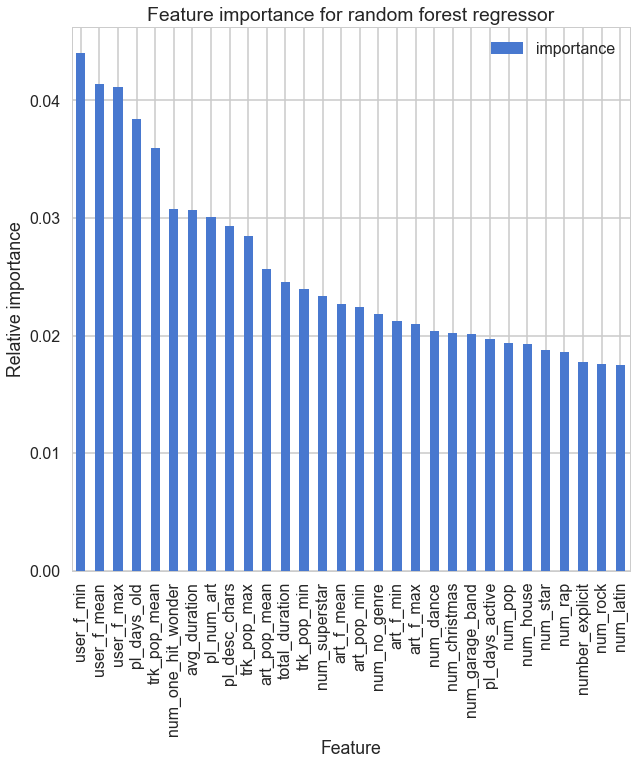

In [60]:
# Build table of relative feature importance
feature_importance = pd.DataFrame(index=x_train.columns, 
                                  data=rf.feature_importances_, 
                                  columns = ['importance'])

best_30_features = feature_importance.sort_values('importance', ascending=False)[:30]

fig,ax = plt.subplots(figsize=(10,10))
best_30_features.plot(kind='bar',color='b',ax=ax)
ax.set_title('Feature importance for random forest regressor')
ax.set_ylabel('Relative importance')
ax.set_xlabel('Feature')

The 30 most common features above are as expected - for example:
* The followers of the playlist owner are highly predictive of 
* Having a playlist description makes followers more likely
* One hit wonders and superstars are the most important class of bands in a playlist

Next, let's see how the.  Feature importance tends to fall off after the first 50 features, so let's try fitting all of our models again on the reduced size set to see if the model performs better:

In [61]:
best_50_features = list(feature_importance.sort_values('importance', ascending=False)[:50].index)

x_train_reduced = x_train[best_50_features]
x_test_reduced = x_test[best_50_features]

In [62]:
# Global CV params for GLM models
reg_par = [1e-3,1e-2,1e-1,1.0,1e2,1e3,1e4,1e5]
l1_ratio = [.25,.5,.75]

In [63]:
# Linear Regression
lr2 = LinearRegression().fit(x_train_reduced,y_train)

In [64]:
# Ridge Regression
ridge2 = RidgeCV(alphas=reg_par,cv=5).fit(x_train_reduced,y_train)

In [65]:
# Lasso Regression
lasso2 = LassoCV(alphas=reg_par,cv=5).fit(x_train_reduced,y_train)

In [66]:
# Elastic Net Regression
en2 = ElasticNetCV(l1_ratio=l1_ratio,alphas=reg_par,cv=5).fit(x_train_reduced,y_train)

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [67]:
# k-NN Regression
ks = {'n_neighbors': [4,20,50]}
gridknn2 = GridSearchCV(KNeighborsRegressor(),cv=5,param_grid=ks).fit(x_train_reduced,y_train)

best_k_knn2 = gridknn2.best_params_['n_neighbors']
print('The best k was:',best_k_knn2)

knn2 = KNeighborsRegressor(n_neighbors=best_k_knn2).fit(x_train_reduced,y_train)

The best k was: 50


In [68]:
# Random Forest Regression
trees = {'n_estimators': [25,50,100,200,300,500]}
gridrf2 = GridSearchCV(RandomForestRegressor(max_features='sqrt'),cv=5,param_grid=trees).fit(x_train_reduced,y_train)

rf2 = RandomForestRegressor(max_features='sqrt',n_estimators=best_trees_rf).fit(x_train_reduced,y_train)

In [69]:
# AdaBoost Regression
trees_lr = {'n_estimators': [15,25,50,100], 'base_estimator': [DecisionTreeRegressor(max_depth=3), \
                                                                DecisionTreeRegressor(max_depth=4),\
                                                                DecisionTreeRegressor(max_depth=5)]}
gridab2 = GridSearchCV(AdaBoostRegressor(learning_rate=.1),cv=5,param_grid=trees_lr).fit(x_train_reduced,y_train)

print('The best number of trees was: ',gridab2.best_params_['n_estimators'])

ab2 = AdaBoostRegressor(learning_rate=0.1,**gridab2.best_params_).fit(x_train_reduced,y_train)

The best number of trees was:  50


In [72]:
# XGBoost Regression
xgbp = {'max_depth': [2,3,4,5], 'n_estimators': [25,50,100,150,200]}
gridxgb2 = GridSearchCV(XGBRegressor(seed=9010),cv=5,param_grid=xgbp).fit(x_train_reduced,y_train)

print('The best parameters for xgboost:',*gridxgb2.best_params_.items())
xgb2 = XGBRegressor(seed=9010,**gridxgb2.best_params_).fit(x_train_reduced,y_train)

The best parameters for xgboost: ('max_depth', 3) ('n_estimators', 25)


In [70]:
# SVM Regression
svr_par = {'C': [1e-1,1.0,1e2,1e3,1e4]}
gridsvr2 = GridSearchCV(SVR(),cv=5,param_grid=svr_par).fit(x_train_reduced,y_train)

svm2 = SVR(**gridsvr2.best_params_).fit(x_train_reduced,y_train)

In [74]:
# Results!

lr2_cv_score = cross_val_score(lr2, x_train_reduced, y_train, scoring = 'r2')
print("Linear Regression cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(lr2_cv_score), np.std(lr2_cv_score)))
print('Linear Regression R^2 on full train:',lr2.score(x_train_reduced,y_train))
print('Linear Regression R^2 on test:',lr2.score(x_test_reduced,y_test),"\n")

ridge2_cv_score = cross_val_score(ridge2, x_train_reduced, y_train, scoring = 'r2')
print("Ridge cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(ridge2_cv_score), np.std(ridge2_cv_score)))
print('Ridge Regression R^2 on full train:',ridge2.score(x_train_reduced,y_train))
print('Ridge Regression R^2 on test:',ridge2.score(x_test_reduced,y_test),"\n")

lasso2_cv_score = cross_val_score(lasso2, x_train_reduced, y_train, scoring = 'r2')
print("Lasso cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(lasso2_cv_score), np.std(lasso2_cv_score)))
print('Lasso Regression R^2 on full train:',lasso2.score(x_train_reduced,y_train))
print('Lasso Regression R^2 on test:',lasso2.score(x_test_reduced,y_test),"\n")

en2_cv_score = cross_val_score(en2, x_train_reduced, y_train, scoring = 'r2')
print("Elastic Net cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(en2_cv_score), np.std(en2_cv_score)))
print('Elastic Net Regression R^2 on full train:',en2.score(x_train_reduced,y_train))
print('Elastic Net Regression R^2 on test:',en2.score(x_test_reduced,y_test),"\n")

knn2_cv_score = cross_val_score(knn2, x_train_reduced, y_train, scoring = 'r2')
print("k-NN cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(knn2_cv_score), np.std(knn2_cv_score)))
print('k-NN Regression R^2 on full train:',knn2.score(x_train_reduced,y_train))
print('k-NN Regression R^2 on test:',knn2.score(x_test_reduced,y_test),"\n")

rf2_cv_score = cross_val_score(rf2, x_train_reduced, y_train, scoring = 'r2')
print("Random Forest cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(rf2_cv_score), np.std(rf2_cv_score)))
print('Random Forest Regression R^2 on full train:',rf2.score(x_train_reduced,y_train))
print('Random Forest Regression R^2 on test:',rf2.score(x_test_reduced,y_test),"\n")

ab2_cv_score = cross_val_score(ab2, x_train_reduced, y_train, scoring = 'r2')
print("AdaBoost cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(ab2_cv_score), np.std(ab2_cv_score)))
print('AdaBoost Regression R^2 on full train:',ab2.score(x_train_reduced,y_train))
print('AdaBoost Regression R^2 on test:',ab2.score(x_test_reduced,y_test),"\n")

xgb2_cv_score = cross_val_score(xgb2, x_train_reduced, y_train, scoring = 'r2')
print("XGB cross-validated validating score on training set: Mean={}, Std={}"
      .format(np.mean(xgb2_cv_score), np.std(xgb2_cv_score)))
print('XGB Regression R^2 on full train:',xgb2.score(x_train_reduced,y_train))
print('XGB Regression R^2 on test:',xgb2.score(x_test_reduced,y_test),"\n")

svm2_cv_score = cross_val_score(svm2, x_train_reduced, y_train, scoring = 'r2')
print("SVM cross-validated validation score on training set: Mean={}, Std={}"
      .format(np.mean(svm2_cv_score), np.std(svm2_cv_score)))
print('SVM Regression R^2 on full train:',svm2.score(x_train_reduced,y_train))
print('SVM Regression R^2 on test:',svm2.score(x_test_reduced,y_test),"\n")

Linear Regression cross-validated validation score on training set: Mean=-0.10404422368737314, Std=0.19349222672167976
Linear Regression R^2 on full train: 0.102807293108
Linear Regression R^2 on test: 0.0224559417845 

Ridge cross-validated validation score on training set: Mean=-0.0012099350604610388, Std=0.06014401823558278
Ridge Regression R^2 on full train: 0.0506409957292
Ridge Regression R^2 on test: 0.034960605146 

Lasso cross-validated validation score on training set: Mean=-0.031179089608199113, Std=0.11043536489467987
Lasso Regression R^2 on full train: 0.0835771438137
Lasso Regression R^2 on test: 0.040393327611 



/Users/paulblankley/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Elastic Net cross-validated validation score on training set: Mean=-0.0028709466278603233, Std=0.06259040628484479
Elastic Net Regression R^2 on full train: 0.0742195304118
Elastic Net Regression R^2 on test: 0.0420117696879 

k-NN cross-validated validation score on training set: Mean=0.02365696902444836, Std=0.005290415228039509
k-NN Regression R^2 on full train: 0.0938927608193
k-NN Regression R^2 on test: 0.0471011530949 

Random Forest cross-validated validation score on training set: Mean=-0.012824365374335844, Std=0.17363765832838546
Random Forest Regression R^2 on full train: 0.874413756852
Random Forest Regression R^2 on test: 0.108460311935 

AdaBoost cross-validated validation score on training set: Mean=0.06851789843488665, Std=0.01991264170112891
AdaBoost Regression R^2 on full train: 0.815443417418
AdaBoost Regression R^2 on test: 0.104618730911 

XGB cross-validated validating score on training set: Mean=-0.06831414541031067, Std=0.24532113197831398
XGB Regression R^2 on

We can see above that the model performance on a cross-validated training set is generally worse with the reduced feature set.  So we'll keep our baseline model and our original random forest regressor.  

In [75]:
final_model = rf

### 209 Feature:

As you have probably noticed, the additional clustering from our Word 2 Vec feature, does not add much of anything to the model as a whole. This is likely for two reasons. First, the word 2 vec model could just be too noisy to actually add value to the model.  Second, the playlist name might not be that important in general when you have information about the number of followers of the user who "owns" the playlist.  Essentially, any influence from the name of the playlist, may be close to conditionally independent of the response given one (or a few) of the other variables.  For either of these two reasons, the 209 Word 2 Vec feature does not increase our $R^2$.  To test this hypothesis, we look at a quick difference in the straightforward regression models and take the average of the improvement on test accuracy with the feature vs without.  

In [76]:
# drop_c = ['user_f_max','user_f_mean','user_f_min']
drop_c = ['num_alternative','num_christmas', 'num_country', 'num_dance', 'num_deep', 'num_hip_hop', 'num_metal',\
          'num_house','num_indie', 'num_jazz', 'num_latin', 'num_pop', 'num_rap', 'num_rock', 'num_soul', \
          'num_no_genre']
xtr = x_train.drop(drop_c, axis=1)
xts = x_test.drop(drop_c, axis=1)
xtrn = x_train_no_w2v.drop(drop_c, axis=1)
xtsn = x_test_no_w2v.drop(drop_c,axis=1)

In [77]:
# Linear Regression
lr_xt = LinearRegression().fit(xtr,y_train)
lr_xtn = LinearRegression().fit(xtrn,y_train)

# Ridge Regression
ridge_xt = LassoCV(alphas=reg_par,cv=5).fit(xtr,y_train)
ridge_xtn = LassoCV(alphas=reg_par,cv=5).fit(xtrn,y_train)

# Lasso Regression
lasso_xt = LassoCV(alphas=reg_par,cv=5).fit(xtr,y_train)
lasso_xtn = LassoCV(alphas=reg_par,cv=5).fit(xtrn,y_train)

# Elastic Net Regression
en_xt = ElasticNetCV(l1_ratio=l1_ratio,alphas=reg_par,cv=5).fit(xtr,y_train)
en_xtn = ElasticNetCV(l1_ratio=l1_ratio,alphas=reg_par,cv=5).fit(xtrn,y_train)

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/paulblankley/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [78]:
# Results
print('Ridge Regression with w2v R^2 on train:',ridge_xt.score(xtr,y_train))
print('Ridge Regression with w2v R^2 on test:',ridge_xt.score(xts,y_test))
print('Ridge Regression without w2v R^2 on train:',ridge_xtn.score(xtrn,y_train))
print('Ridge Regression without w2v R^2 on test:',ridge_xtn.score(xtsn,y_test))

print('Lasso Regression with w2v R^2 on train:',lasso_xt.score(xtr,y_train))
print('Lasso Regression with w2v R^2 on test:',lasso_xt.score(xts,y_test))
print('Lasso Regression without w2v R^2 on train:',lasso_xtn.score(xtrn,y_train))
print('Lasso Regression without w2v R^2 on test:',lasso_xtn.score(xtsn,y_test))

print('Elastic Net Regression with w2v R^2 on train:',en_xt.score(xtr,y_train))
print('Elastic Net Regression with w2v R^2 on test:',en_xt.score(xts,y_test))
print('Elastic Net Regression without w2v R^2 on train:',en_xtn.score(xtrn,y_train))
print('Elastic Net Regression without w2v R^2 on test:',en_xtn.score(xtsn,y_test))

Ridge Regression with w2v R^2 on train: 0.0812653316532
Ridge Regression with w2v R^2 on test: 0.0392014393826
Ridge Regression without w2v R^2 on train: 0.0797564462589
Ridge Regression without w2v R^2 on test: 0.038960622454
Lasso Regression with w2v R^2 on train: 0.0812653316532
Lasso Regression with w2v R^2 on test: 0.0392014393826
Lasso Regression without w2v R^2 on train: 0.0797564462589
Lasso Regression without w2v R^2 on test: 0.038960622454
Elastic Net Regression with w2v R^2 on train: 0.0728789565471
Elastic Net Regression with w2v R^2 on test: 0.0412664603581
Elastic Net Regression without w2v R^2 on train: 0.0810526332472
Elastic Net Regression without w2v R^2 on test: 0.0389881477994


In [79]:
# avg_training_dif = ((ridge_xt.score(xtr,y_train)-ridge_xtn.score(xtrn,y_train))/ridge_xtn.score(xtrn,y_train) \
#                     +(lasso_xt.score(xtr,y_train)-lasso_xtn.score(xtrn,y_train))/lasso_xtn.score(xtrn,y_train) \
#                     +(en_xt.score(xtr,y_train)-en_xtn.score(xtrn,y_train))/en_xtn.score(xtrn,y_train))/3.0
avg_test_dif = ((ridge_xt.score(xts,y_test)-ridge_xtn.score(xtsn,y_test))/ridge_xtn.score(xtsn,y_test) \
                +(lasso_xt.score(xts,y_test)-lasso_xtn.score(xtsn,y_test))/lasso_xtn.score(xtsn,y_test) \
                +(en_xt.score(xts,y_test)-en_xtn.score(xtsn,y_test))/en_xtn.score(xtsn,y_test))/3.0
print('The average percent improvement in R^2 for each model with W2V feature: {0:.4}%.'.format(avg_test_dif*100))

The average percent improvement in R^2 for each model with W2V feature: 2.36%.


#### Thoughts:

We cannot say for sure that these genre variables confound the feature we made for our 209 part, but there is improvement with the feature vs without it where there was previously none.  In addition to that, these features are the msot intiuative to remove to check for improvement, because they are realted to the distribution of genres (i.e. the type of music in a playlist), which is what our hypothesis about the playlist names was based on.  We said playlist name would be a good proxy for the contents, and wanted to create another variable from the user about the contents of the playlist. 

### Generative Model:

Here we will make our generative model.

In [80]:
gnr_cols = ['trk_id','art_name','trk_name','has_alternative', 'has_christmas','has_country', 'has_dance',\
            'has_deep', 'has_hip_hop', 'has_metal', 'has_house','has_indie', 'has_jazz','has_latin', \
            'has_pop','has_rap', 'has_rock','has_soul']
generative_data = df_full[gnr_cols].groupby('trk_id',as_index=False).agg('first')

pred_df = pd.DataFrame({'pred_pop': final_model.predict(x_train.append(x_test)),'pl_id': train.append(test)['pl_id']})
df_pred_pop = pd.merge(df_full, pred_df, how='left', on='pl_id')
pop_cols = ['trk_id','pl_followers','pred_pop']
pop_data = df_pred_pop[pop_cols].groupby('trk_id',as_index=False).sum()

gen_data = pd.merge(generative_data,pop_data,how='inner',on='trk_id')
gen_data.head()

,trk_id,art_name,trk_name,has_alternative,has_christmas,has_country,has_dance,has_deep,has_hip_hop,has_metal,has_house,has_indie,has_jazz,has_latin,has_pop,has_rap,has_rock,has_soul,pl_followers,pred_pop
0,0001ETU9DQ1EDGwQODbyLP,Luke Cole,Saturn,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,6,-0.188880
1,000RjY5jCULjuIqWMNcMWP,Kerobia,Isburt,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1130,-0.100272
2,000cAxMxUfuDlvPYIVrrZ4,Tantric,Mind Control,True,False,False,False,False,False,True,False,False,False,False,False,True,True,False,2258,-0.027733
3,000xQL6tZNLJzIrtIgxqSl,ZAYN,Still Got Time,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,186556,4.376180
4,000xYdQfIZ4pDmBGzQalKU,Luan Santana,"Eu, Você, O Mar e Ela",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,449,-0.429067


In [83]:
def generative_model(genre,df,size=20):
    """ Generate a playlist given a genre in our valid list and the realted dataframe for generation.
    ------
    Args: genre; str, a valid genre from our list of genres.
          df; pandas dataframe with the correct predicted std followers and pl followers 
              columns, unique on trk_id
    ------
    Returns: list of (trk_id, trk_name) pairs based on genre and pred success.
    """
    valid_genres = ['alternative', 'christmas','country', 'dance','deep', 'hip_hop', 'metal', \
                    'house','indie', 'jazz','latin', 'pop','rap', 'rock','soul']
    if genre not in valid_genres:
        raise ValueError('You must enter a genre we have! See the drop down list.')

    possible = df[df['has_{}'.format(genre)]==True][['trk_id','art_name','trk_name','pl_followers','pred_pop']]

    # turn the sum of popularity pred into a probability
    hold_pp = (possible['pred_pop'].values - min(possible['pred_pop'])) \
                                        / (max(possible['pred_pop'])-min(possible['pred_pop']))
    probs_pp = hold_pp/sum(hold_pp)
    
    # turn the sum of pl_followers into a probability
    hold_plf = (possible['pl_followers'].values - min(possible['pl_followers'])) \
                                        / (max(possible['pl_followers'])-min(possible['pl_followers']))
    probs_plf = hold_plf/sum(hold_plf)  
    
    # Randomly sample with probbaly given by predicted popularity 
    out = possible.sample(size,weights=probs_pp)[['art_name','trk_name']]
    return out

In [84]:
generative_model('latin',gen_data)

,art_name,trk_name
109565,Kabah,Al Pasar
71223,J Alvarez,Pideme Lo Que Quieras
29305,Pesado,Ahora que ya no estás
9722,Joey Montana,Picky
121920,J Balvin,Yo Te Lo Dije
47566,"Tito ""El Bambino""",Flow Natural
85708,Chino & Nacho,Lo Que No Sabes Tú
98479,Fuego,35 Pa Las 12 (feat. J Balvin)
44989,Alejandra Guzman,Ya Lo Veía Venir - feat. Moderatto
7490,Kinky,Avión
